# 5. Covid-19 samples from healthy, mild and severe patients
Chen ST, Park MD, Del Valle DM, Buckup M, Tabachnikova A, Thompson RC, et al. A shift in lung macrophage composition is associated with COVID-19 severity and recovery. Sci Transl Med. 2022;14:eabn5168

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro
from scanpro.get_transformed_props import get_transformed_props

In [2]:
#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

In [3]:
# path where figures are going to be saved
FIG_PATH = 'plots'

In [4]:
def convert_counts_to_df(counts, prop_cols=None, meta_cols=None, n_cells=1, column_name="Cluster"):
    """ Convert a cell count matrix to a dataframe in long format."""

    counts = counts.copy()

    #If not given, try to get prop_cols and meta_cols automatically
    if prop_cols is None:
        dtypes = counts.dtypes.astype(str)
        prop_cols = [col for i, col in enumerate(counts.columns) if "float" in dtypes[i] or "int" in dtypes[i]]
        
    if meta_cols is None:
        meta_cols = [col for col in counts.columns if col not in prop_cols]

    # Multiply proportions with n_cells
    counts[prop_cols] *= n_cells
    counts[prop_cols] = counts[prop_cols].astype(int)
    
    # Melt into long format (similar to adata.obs)
    counts_melt = pd.melt(counts, id_vars=meta_cols, value_vars=prop_cols, 
                          var_name=column_name, value_name="count")

    # Duplicate rows based on number of cells
    counts_long = counts_melt.loc[counts_melt.index.repeat(counts_melt["count"])].reset_index(drop=True)
    counts_long.drop(columns="count", inplace=True)
    counts_long.index = ["cell_" + str(i) for i in range(1, len(counts_long) + 1)]
    
    return counts_long

------------------

## Read data

In [5]:
covid_counts = pd.read_csv("data/covid_counts.tsv", sep='\t')
covid = convert_counts_to_df(covid_counts, column_name="celltype")

In [6]:
covid

,sample,sample_new,group,disease,hasnCoV,celltype
cell_1,C100,HC3,HC,N,N,B
cell_2,C100,HC3,HC,N,N,B
cell_3,C100,HC3,HC,N,N,B
cell_4,C100,HC3,HC,N,N,B
cell_5,C100,HC3,HC,N,N,B
...,...,...,...,...,...,...
cell_65809,C52,HC2,HC,N,N,pDC
cell_65810,GSM3660650,HC4,HC,N,N,pDC
cell_65811,GSM3660650,HC4,HC,N,N,pDC
cell_65812,GSM3660650,HC4,HC,N,N,pDC


----------

## Run Scanpro

### Logit

In [7]:
out_covid_logit = scanpro.scanpro(covid, clusters_col='celltype', 
                                          conds_col='group', samples_col='sample_new')
out_covid_logit.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,f_statistics,p_values,adjusted_p_values
celltype,,,,,,,
B,0.003343,0.003503,0.012990,0.004005,2.394586,9.121040e-02,1.303006e-01
Epithelial,0.053652,0.130246,0.051903,0.118455,1.844057,1.581744e-01,1.977180e-01
Macrophages,0.750870,0.735290,0.512996,0.604316,1.626906,1.965368e-01,2.183742e-01
Mast,0.001064,0.002337,0.002220,0.001699,0.700981,4.960984e-01,4.960984e-01
NK,0.016425,0.008894,0.052466,0.017979,5.422331,4.416841e-03,1.104210e-02
Neutrophil,0.024418,0.000000,0.001204,0.055594,34.534717,9.992007e-16,9.992007e-15
Plasma,0.015818,0.000224,0.002150,0.050913,8.817685,1.480908e-04,7.404538e-04
T,0.117241,0.094594,0.325030,0.137097,3.155124,4.263311e-02,8.526622e-02
mDC,0.014860,0.023776,0.030831,0.008876,2.484229,8.338983e-02,1.303006e-01


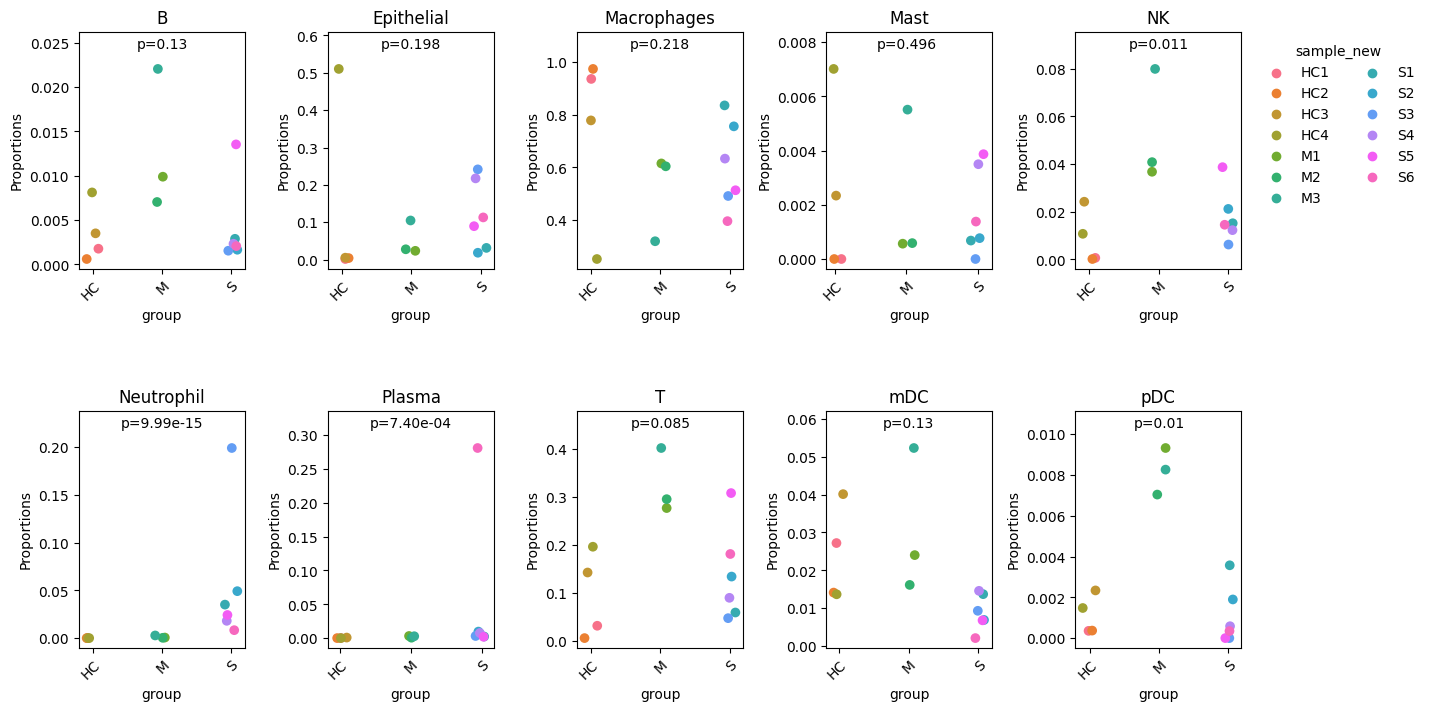

In [8]:
out_covid_logit.plot(n_columns=5, save=f"{FIG_PATH}/covid19_boxplot.pdf")

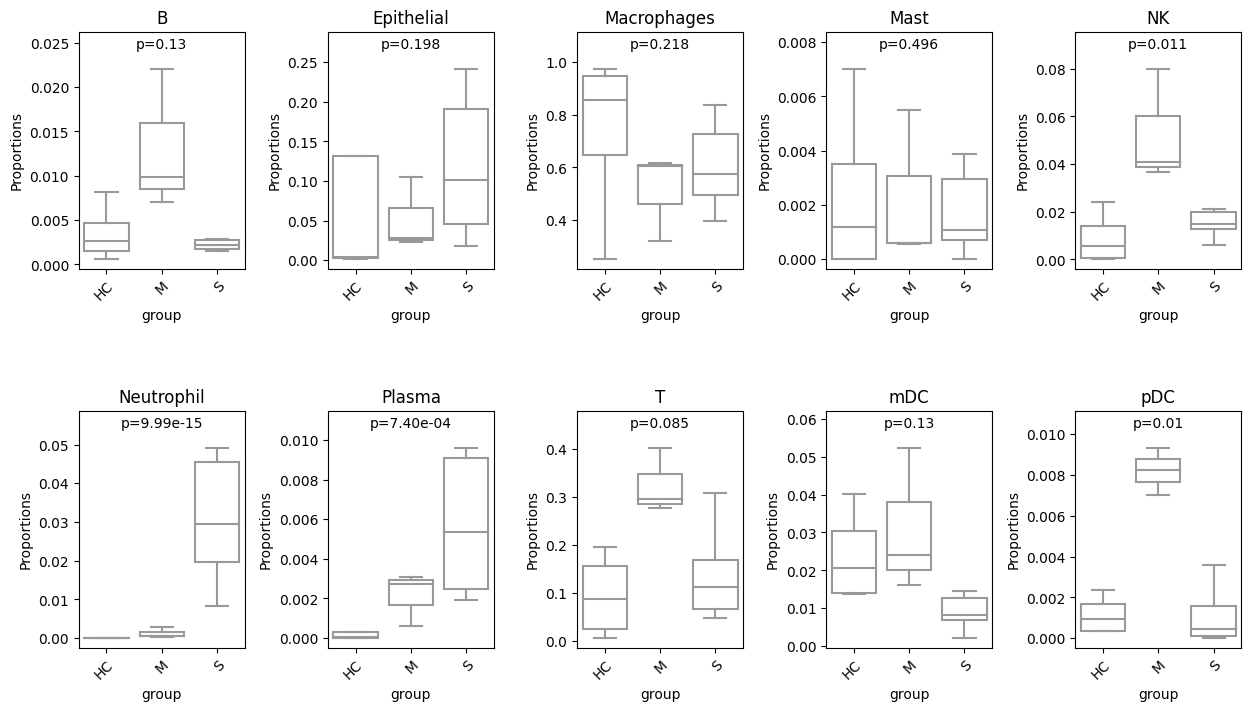

In [9]:
out_covid_logit.plot(kind='boxplot', n_columns=5, save=f"{FIG_PATH}/covid19_boxplot.pdf")

In [10]:
out_covid_logit.results.to_csv("results/covid_scanpro_rep_logit.tsv", sep="\t")

### arcsin

In [11]:
out_covid_arcsin = scanpro.scanpro(covid, clusters_col='celltype', samples_col='sample_new',
                                   conds_col='group', transform='arcsin')
out_covid_arcsin.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,f_statistics,p_values,adjusted_p_values
celltype,,,,,,,
B,0.003343,0.003503,0.012990,0.004005,3.180201,0.041577,0.069296
Epithelial,0.053652,0.130246,0.051903,0.118455,0.310375,0.733172,0.814636
Macrophages,0.750870,0.735290,0.512996,0.604316,1.239140,0.289633,0.362041
Mast,0.001064,0.002337,0.002220,0.001699,0.046515,0.954550,0.954550
NK,0.016425,0.008894,0.052466,0.017979,7.520691,0.000542,0.001806
Neutrophil,0.024418,0.000000,0.001204,0.055594,7.791165,0.000413,0.001806
Plasma,0.015818,0.000224,0.002150,0.050913,1.400168,0.246556,0.352222
T,0.117241,0.094594,0.325030,0.137097,5.458288,0.004261,0.010652
mDC,0.014860,0.023776,0.030831,0.008876,5.037225,0.006492,0.012983


In [12]:
out_covid_arcsin.results.to_csv("results/covid_scanpro_rep_arcsin.tsv", sep="\t")

----------

## Without replicates

### Logit

In [13]:
out_covid_boot_logit = scanpro.scanpro(covid, clusters_col='celltype',
                                       conds_col='group', n_reps=8)

out_covid_boot_logit.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 13.07 seconds


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,p_values
group,,,,,
B,0.003343,0.003325,0.008097,0.003378,2.159916e-01
Epithelial,0.053652,0.062775,0.029298,0.048765,3.594310e-02
Macrophages,0.750870,0.848653,0.601294,0.720370,1.080046e-02
Mast,0.001064,0.000831,0.000633,0.000963,3.909767e-01
NK,0.016425,0.005134,0.040827,0.017599,2.229718e-03
Neutrophil,0.024418,0.000000,0.000396,0.043225,9.566691e-04
Plasma,0.015818,0.000341,0.001840,0.025600,5.378281e-03
T,0.117241,0.056588,0.287474,0.129447,2.806666e-10
mDC,0.014860,0.021635,0.022562,0.008487,1.065620e-01


In [14]:
out_covid_boot_logit.results.to_csv("results/covid_scanpro_norep_logit.tsv", sep="\t")

### Arcsin

In [15]:
out_covid_boot_arcsin = scanpro.scanpro(covid, clusters_col='celltype',
                                       conds_col='group', n_reps=8, transform='arcsin')

out_covid_boot_arcsin.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 12.23 seconds


,baseline_props,mean_props_HC,mean_props_M,mean_props_S,p_values
group,,,,,
B,0.003343,0.003325,0.008097,0.003378,2.080617e-01
Epithelial,0.053652,0.062775,0.029298,0.048765,2.120833e-01
Macrophages,0.750870,0.848653,0.601294,0.720370,5.107354e-04
Mast,0.001064,0.000831,0.000633,0.000963,7.353197e-01
NK,0.016425,0.005134,0.040827,0.017599,4.478512e-03
Neutrophil,0.024418,0.000000,0.000396,0.043225,1.569135e-07
Plasma,0.015818,0.000341,0.001840,0.025600,1.066963e-04
T,0.117241,0.056588,0.287474,0.129447,4.466625e-06
mDC,0.014860,0.021635,0.022562,0.008487,2.454773e-01


In [16]:
out_covid_boot_arcsin.results.to_csv("results/covid_scanpro_norep_arcsin.tsv", sep="\t")

-----------------

## Compare results
* we will take the `-log(p-value)` to compare

In [17]:
for result in [out_covid_logit, out_covid_boot_logit, out_covid_arcsin, out_covid_boot_arcsin]:
    print(result.results.iloc[:,-1])

celltype
B              1.303006e-01
Epithelial     1.977180e-01
Macrophages    2.183742e-01
Mast           4.960984e-01
NK             1.104210e-02
Neutrophil     9.992007e-15
Plasma         7.404538e-04
T              8.526622e-02
mDC            1.303006e-01
pDC            1.024157e-02
Name: adjusted_p_values, dtype: float64
group
B              2.159916e-01
Epithelial     3.594310e-02
Macrophages    1.080046e-02
Mast           3.909767e-01
NK             2.229718e-03
Neutrophil     9.566691e-04
Plasma         5.378281e-03
T              2.806666e-10
mDC            1.065620e-01
pDC            1.260565e-01
Name: p_values, dtype: float64
celltype
B              0.069296
Epithelial     0.814636
Macrophages    0.362041
Mast           0.954550
NK             0.001806
Neutrophil     0.001806
Plasma         0.352222
T              0.010652
mDC            0.012983
pDC            0.001806
Name: adjusted_p_values, dtype: float64
group
B              2.080617e-01
Epithelial     2.120833e-01
Mac

In [18]:
covid_compare = {'scanpro': -np.log(out_covid_arcsin.results.iloc[:,-1].to_list()),
                 'scanpro_noRep': -np.log(out_covid_boot_arcsin.results.iloc[:,-1].to_list())}

covid_compare = pd.DataFrame(covid_compare, index=out_covid_arcsin.results.index)

annot = {'scanpro': ['*' if value < 0.05 else '' for value in out_covid_arcsin.results.iloc[:,-1].to_list()],
         'scanpro_noRep': ['*' if value < 0.05 else '' for value in out_covid_boot_arcsin.results.iloc[:,-1].to_list()]}

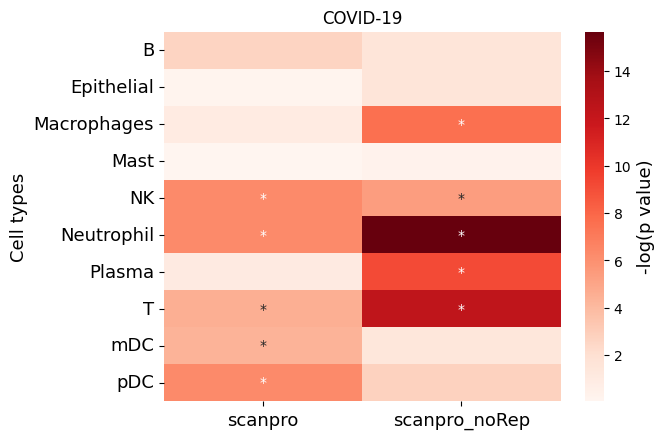

In [19]:
ax = sns.heatmap(covid_compare, annot=pd.DataFrame(annot), fmt='', cmap='Reds', cbar_kws={'label': '-log(p value)'})
ax.set_ylabel('Cell types', fontsize=13)

ax.set_title("COVID-19")

plt.tick_params(axis='both', which='major', labelsize=13)
ax.figure.axes[-1].yaxis.label.set_size(13)

#plt.savefig(f'{FIG_PATH}/covid_nativ_vs_boot.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{FIG_PATH}/covid_nativ_vs_boot.pdf', dpi=300, bbox_inches='tight')

plt.show()

#### Plasma cells have one sample as outlier, which affects the bootstrapping result

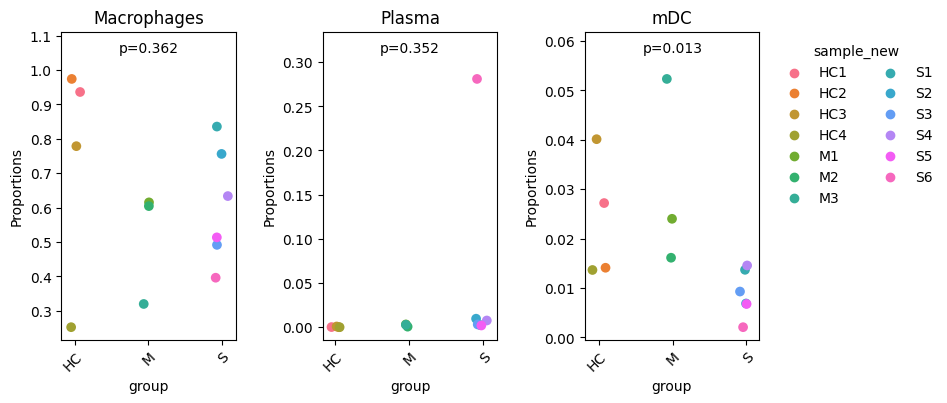

In [20]:
out_covid_arcsin.plot(n_columns=5, clusters=['Macrophages', 'Plasma', 'mDC'],
                      save=f'{FIG_PATH}/covid_stripplot_example.pdf')

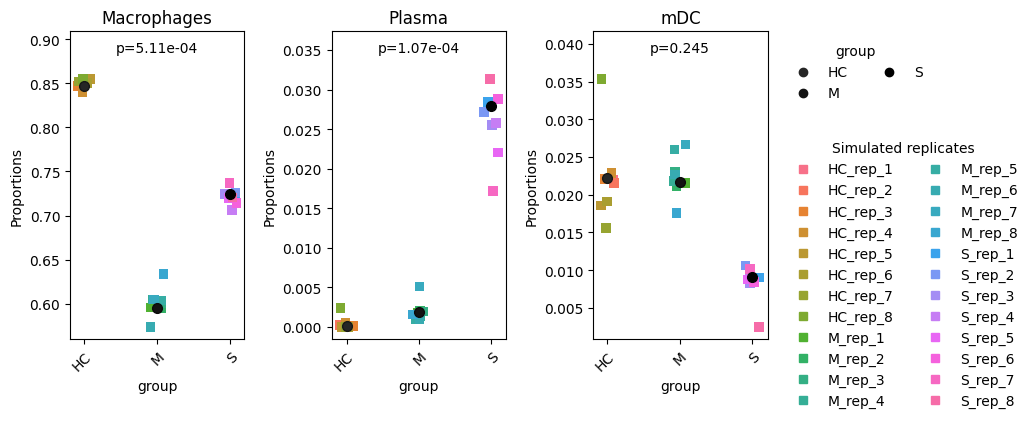

In [21]:
out_covid_boot_arcsin.plot(clusters=['Macrophages', 'Plasma', 'mDC'],
                           save=f'{FIG_PATH}/covid_stripplot_norep_example.pdf')